# Import Libraries

In [ ]:
# Import kagglehub to download the dataset
import kagglehub
atifaliak_youtube_comments_dataset_path = kagglehub.dataset_download('atifaliak/youtube-comments-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:
import numpy as np
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-comments-dataset/YoutubeCommentsDataSet.csv


In [ ]:
#for data reading and preprocessing
import os
import string
import re
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#model building (machine learning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

#model building (transformer)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW,lr_scheduler
import torch.nn.functional as F

#model evaluation
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data = pd.read_csv("./kaggle/YoutubeCommentsDataSet.csv")

## Data Preprocessing

In [ ]:
data.isna().sum()

,0
Comment,44
Sentiment,0


In [ ]:
#removing nana
data.dropna(inplace=True)

In [ ]:
data['Sentiment'].value_counts(normalize=True)

,proportion
Sentiment,
positive,0.620889
neutral,0.251851
negative,0.127260


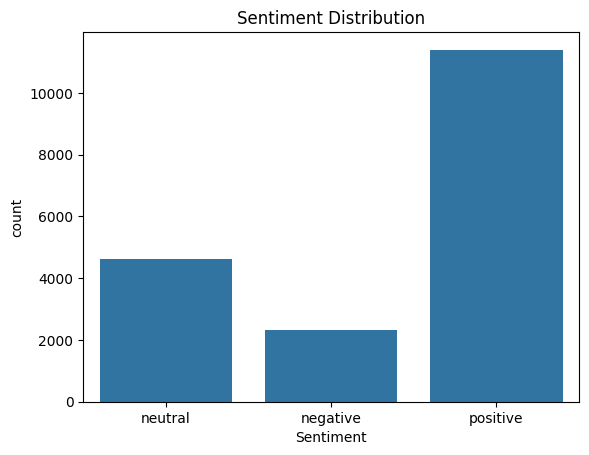

In [ ]:
sns.countplot(x =data['Sentiment'])
plt.title("Sentiment Distribution")
plt.show()

In [ ]:
n = data['Sentiment'].value_counts().values.min() #we will take only minimum number of samples
random_state = 42

pos_data = data[data['Sentiment']=='positive'].sample(n=n,random_state = random_state)
neu_data = data[data['Sentiment']=='neutral'].sample(n=n,random_state = random_state)
neg_data = data[data['Sentiment']=='negative'].sample(n=n,random_state = random_state)
final_data = pd.concat([pos_data, neg_data, neu_data]).reset_index(drop=True)
final_data.shape

(7011, 2)

In [ ]:
final_data['Sentiment'].value_counts()

,count
Sentiment,
positive,2337
negative,2337
neutral,2337


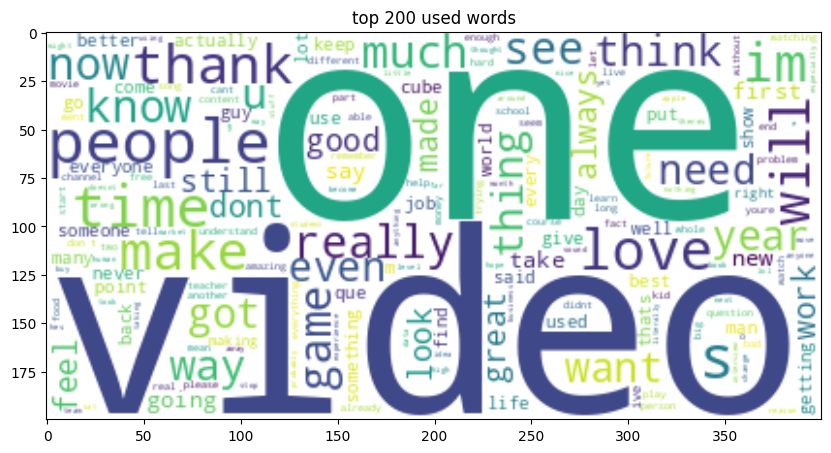

In [ ]:
#checking word distribution
sent_list = final_data['Comment'].tolist()
wc  = WordCloud(background_color='white',
                max_words=200,
                random_state=random_state,
                stopwords = STOPWORDS)
wc.generate(" ".join(sent_list))
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')
plt.title("top 200 used words")
plt.show()

In [ ]:
word_dict = {
    "im" : "i am",
    "u" : "you",
    "cant": "can not",
    "can't" : "can not",
    "youre" : "you are",
    "you're" : "you are",
    "ive" : "i have",
    "i've" : "i have"
}

PUNC = string.punctuation
#removing ?
set1 = PUNC[:20]
set2 = PUNC[21:]
PUNC = set1+set2
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.discard('not') #removing the word not from the stopwords
lemitizer = WordNetLemmatizer()

In [ ]:
def preprocessing(text):
  text = text.lower()
  clean_text = re.sub("\'t"," not",text) #changing 't to not
  clean_text =re.sub("\'re"," are",clean_text) #changing 're to are
  clean_text =re.sub("\'m"," am",clean_text) #changing 'm  to am
  clean_text = re.sub("[^A-Za-z0-9]"," ",clean_text) #removing all the charecters except A-Za-a0-9
  clean_text = re.sub("\s+"," ",clean_text) #removing extra space
  clean_text = clean_text.strip() #removing training spaces

  words = clean_text.split(" ")
  words = [word_dict.get(word,word) for word in words]
  final_text = " ".join(words)
  clean_words = [word for word in final_text.split(" ") if word not in STOPWORDS]
  return " ".join(clean_words)

In [ ]:
final_data['clean_text'] = final_data['Comment'].apply(preprocessing)

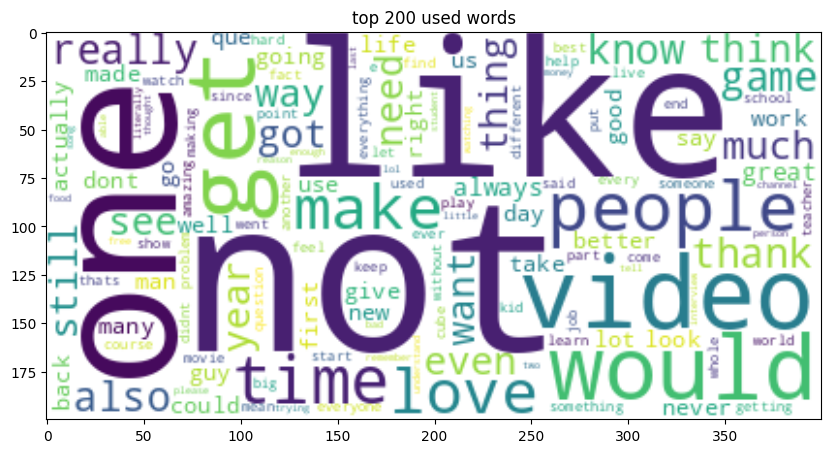

In [ ]:
#checking word distribution after cleaning
sent_list = final_data['clean_text'].tolist()
wc  = WordCloud(background_color='white',
                max_words=200,
                random_state=random_state,
                stopwords = STOPWORDS)
wc.generate(" ".join(sent_list))
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')
plt.title("top 200 used words")
plt.show()

## Train-test spliting

In [ ]:
# train test spliting
X = final_data['clean_text']
Y = final_data['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state = random_state, stratify=Y)

## Encoder

In [ ]:
#label encoding
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_array = encoder.transform(y_train)
y_test_array = encoder.transform(y_test)


In [ ]:
#tfidf vecctorization of the text
tfidf = TfidfVectorizer(max_features=5000,
                        ngram_range=(1,3))

tfidf.fit(X_train)
X_train_array = tfidf.transform(X_train)
X_test_array = tfidf.transform(X_test)

In [ ]:
def get_score(model):
  kf = StratifiedKFold(random_state=random_state,
                       shuffle=True,
                       n_splits=10)
  auc = cross_val_score(model,X_train_array,y_train_array, scoring='f1_weighted',cv=kf)

  return auc.mean()

In [ ]:
res = pd.Series([get_score(MultinomialNB(alpha=(i))) for i in np.arange(1,10,0.1)],index = np.arange(1, 10, 0.1))
best_alpha = np.argmax(res)
best_alpha = np.round(res.idxmax(), 2)

Best Alpha for the model: 1.0


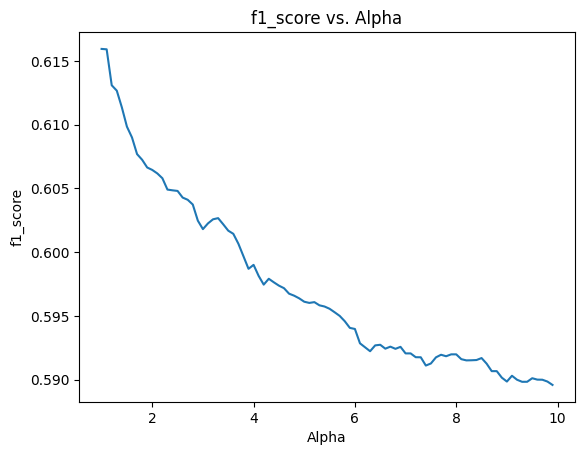

In [ ]:
print(f"Best Alpha for the model: {best_alpha}")
plt.plot(res)
plt.title('f1_score vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('f1_score')
plt.show()

## Confusion matrix

In [ ]:
mb = MultinomialNB(alpha=best_alpha)
mb.fit(X_train_array,y_train_array)
y_pred = mb.predict(X_test_array)

print(classification_report(y_test_array,y_pred))

              precision    recall  f1-score   support

           0       0.57      0.78      0.66       467
           1       0.81      0.35      0.49       468
           2       0.68      0.80      0.74       468

    accuracy                           0.65      1403
   macro avg       0.69      0.65      0.63      1403
weighted avg       0.69      0.65      0.63      1403



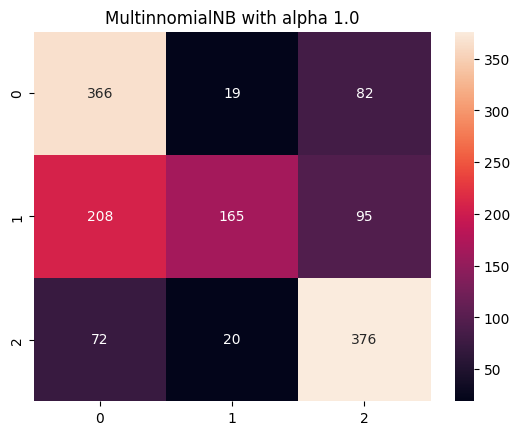

In [ ]:
sns.heatmap(confusion_matrix(y_test_array,y_pred),annot=True, fmt = '.0f')
plt.title(f"MultinnomialNB with alpha {best_alpha}")
plt.show()

# Using BERT

In [ ]:
MODEL_NAME = "google-bert/bert-base-uncased"
BATCH_SIZE = 32
EPOCHS = 4
MAX_LEN = 512

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # import pretrained BERT as decoder

In [ ]:
def bert_preprocessing(data):
  input_ids = []
  attention_masks = []
  for sent in data:
      encode_sent = tokenizer.encode_plus(text= sent, #it will  preprocess the text
                                      add_special_tokens=True,
                                      max_length=MAX_LEN,#add [CLS] and [SEP] tokens
                                      padding="max_length",  #it will padd to max length
                                      truncation = True,
                                      return_attention_mask=True) # Return attention mask
      input_ids.append(encode_sent.get('input_ids'))
      attention_masks.append(encode_sent.get('attention_mask'))

  input_ids_tensor = torch.tensor(input_ids)
  attention_mask_tensor = torch.tensor(attention_masks)

  return input_ids_tensor, attention_mask_tensor

In [ ]:
#we will use final_data comment
X = final_data['Comment'].values
Y = final_data['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state = random_state, stratify=Y)
encoder_bert = LabelEncoder()
encoder_bert.fit(y_train)
y_train_array = encoder_bert.transform(y_train)
y_test_array = encoder_bert.transform(y_test)

y_train_tensor = torch.tensor(y_train_array).to(device)
y_test_tensor = torch.tensor(y_test_array).to(device)

In [ ]:
train_input_ids, train_attention_mask = bert_preprocessing(X_train)
test_input_ids, test_attention_mask = bert_preprocessing(X_test)
train_input_ids = train_input_ids.to(device)
train_attention_mask = train_attention_mask.to(device)
test_input_ids = test_input_ids.to(device)
test_attention_mask = test_attention_mask.to(device)

In [ ]:
print("Training Data\n")
print("Input ids: ",train_input_ids.dtype, train_input_ids.device)
print("attention masks: ",train_attention_mask.dtype, train_attention_mask.device)
print("Labels: ",y_train_tensor.dtype, y_train_tensor.device)
print("=="*20)
print("Testing Data\n")
print("Input ids: ",test_input_ids.dtype, test_input_ids.device)
print("attention masks: ",test_attention_mask.dtype, test_attention_mask.device)
print("Labels: ",y_test_tensor.dtype, y_test_tensor.device)

Training Data

Input ids:  torch.int64 cuda:0
attention masks:  torch.int64 cuda:0
Labels:  torch.int64 cuda:0
Testing Data

Input ids:  torch.int64 cuda:0
attention masks:  torch.int64 cuda:0
Labels:  torch.int64 cuda:0


## Dataset and dataloder

In [ ]:
class customDataset:
  def __init__(self,input_ids,attention_mask,labels):
    self.input_ids = input_ids
    self.attention_mask = attention_mask
    self.labels = labels

  def __len__(self):
    return self.input_ids.shape[0]

  def __getitem__(self,index):
    return {
        "input_ids" : self.input_ids[index],
        "attention_mask" : self.attention_mask[index],
        "labels" : self.labels[index]
    }



In [ ]:
train_dataset = customDataset(train_input_ids,train_attention_mask,y_train_tensor)
test_dataset = customDataset(test_input_ids,test_attention_mask,y_test_tensor)

In [ ]:
# Use RandomSampler for training (shuffles the data)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

# Use SequentialSampler for testing (keeps data in order)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

In [ ]:
batch = next(iter(train_dataloader))
print(batch["input_ids"].shape)

torch.Size([32, 512])


In [ ]:
class Bertclassifier(nn.Module):
  def __init__(self,freeze_bert = False):
    super().__init__()
    D_input,D_hidden,D_out = 768,64,encoder_bert.classes_.shape[0] #using encoder class to determine the final output
    self.bert = BertModel.from_pretrained(MODEL_NAME)
    self.layers = nn.Sequential(
        nn.Linear(D_input,D_hidden),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(D_hidden,D_hidden),
        nn.ReLU(),
        nn.Linear(D_hidden,D_out))

    # Freeze the BERT model
    if freeze_bert:
         for param in self.bert.parameters():
            param.requires_grad = False

  def forward(self,input_ids,attention_mask):
    bert_out = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
    last_hidden_state = bert_out[0][:,0,:]
 #this will extract the [CLS] token. This is taken out the last hidden state. Required for classification
    logits = self.layers(last_hidden_state)

    return logits


In [ ]:
#compute class weights for imbalance data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_array), y=y_train_array)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
def initiate_model(freeze_bert = False):
  bert_classifier = Bertclassifier(freeze_bert = freeze_bert)
  bert_classifier.to(device)

  optimizer = AdamW(bert_classifier.parameters())

  # total_steps = len(train_dataloader)*epochs
  # schduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

  return bert_classifier, optimizer

def set_seed(seed_value=random_state):
    """Set seed for reproducibility.
    """
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, epochs = 2, test_dataloder = None, eval = False, weight = None):
  print("Start training...")
  loss_fn = nn.CrossEntropyLoss(weight=weight.to(device))
  for epoch_i in range(epochs):
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9}")
    total_loss, batch_loss, batch_counts = 0, 0, 0
    model.train()

    for step, batch in enumerate(train_dataloader):
      batch_counts += 1
      b_input_ids, b_attention_mask, b_labels = tuple(batch[t].to(device) for t in batch)

      model.zero_grad()
      logits = model(b_input_ids,b_attention_mask)
      loss = loss_fn(logits, b_labels)

      batch_loss += loss.item()
      total_loss += loss.item()

      #backward propagation
      loss.backward()

      #putting clipnorm to avoid exploding gradient
      nn.utils.clip_grad_norm_(model.parameters(),1.0)

      optimizer.step()
      # scheduler.step()

      if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
        print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9}")
        # Reset batch tracking variables
        batch_loss, batch_counts = 0, 0
    avg_train_loss = total_loss / len(train_dataloader)

    print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
    if eval == True:
        # After the completion of each training epoch, measure the model's performance
        # on our validation set.
        val_loss, val_accuracy = evaluate(model, test_dataloader,loss_fn)

        # Print performance over the entire training data
        # time_elapsed = time.time() - t0_epoch

        print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f}")
        print("-"*70)
    print("\n")

  print("Training complete!")

def evaluate(model, val_dataloader,loss_fn):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(batch[t].to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
bert_classifier, optimizer = initiate_model(freeze_bert = True)
train(model = bert_classifier,
      train_dataloader = train_dataloader,
      test_dataloder = test_dataloader,
      epochs=2,
      eval=True,
      weight = class_weights)

Start training...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
   1    |   20    |   1.066369   |     -      |     -    
   1    |   40    |   0.942954   |     -      |     -    
   1    |   60    |   0.838555   |     -      |     -    
   1    |   80    |   0.746400   |     -      |     -    
   1    |   100   |   0.796159   |     -      |     -    
   1    |   120   |   0.751116   |     -      |     -    
   1    |   140   |   0.778077   |     -      |     -    
   1    |   160   |   0.716945   |     -      |     -    
   1    |   175   |   0.681440   |     -      |     -    
----------------------------------------------------------------------
   1    |    -    |   0.818292   |  0.637213  |   72.41  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
   2    |   20    |   0.668968   |     -      |     -    
   2    |   40    |   0.699936   |     -      |     -    
   2    |   60    |   0.66

In [ ]:
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(batch[t].to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
probs = bert_predict(bert_classifier, test_dataloader)
y_pred = np.argmax(probs,axis=1)

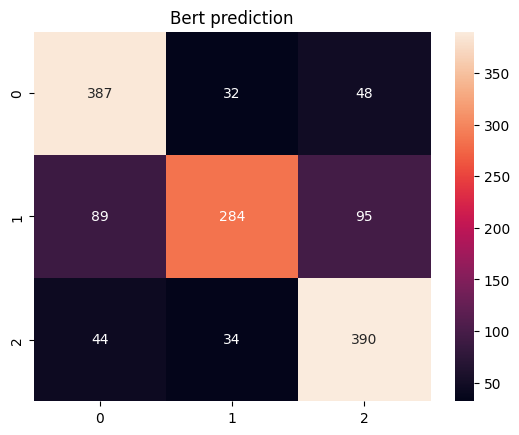

In [ ]:
sns.heatmap(confusion_matrix(y_test_array,y_pred),annot=True, fmt = '.0f')
plt.title("Bert prediction")
plt.show()

# Using BERT on complete data

In [ ]:
X = data['Comment']
Y = data['Sentiment']


X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state = random_state, stratify=Y)
encoder_bert1 = LabelEncoder()
encoder_bert1.fit(y_train)
y_train_array = encoder_bert1.transform(y_train)
y_test_array = encoder_bert1.transform(y_test)

y_train_tensor = torch.tensor(y_train_array).to(device)
y_test_tensor = torch.tensor(y_test_array).to(device)

In [ ]:
train_input_ids, train_attention_mask = bert_preprocessing(X_train)
test_input_ids, test_attention_mask = bert_preprocessing(X_test)
train_input_ids = train_input_ids.to(device)
train_attention_mask = train_attention_mask.to(device)
test_input_ids = test_input_ids.to(device)
test_attention_mask = test_attention_mask.to(device)

In [ ]:
train_dataset = customDataset(train_input_ids,train_attention_mask,y_train_tensor)
test_dataset = customDataset(test_input_ids,test_attention_mask,y_test_tensor)

# Use RandomSampler for training (shuffles the data)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler,drop_last=False)

# Use SequentialSampler for testing (keeps data in order)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler,drop_last=False)

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_array), y=y_train_array)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
bert_classifier, optimizer = initiate_model(freeze_bert = True)
train(model = bert_classifier,
      train_dataloader = train_dataloader,
      test_dataloder = test_dataloader,
      epochs=4,
      eval=True,
      weight=class_weights)

Start training...
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
   1    |   20    |   1.070919   |     -      |     -    
   1    |   40    |   0.975342   |     -      |     -    
   1    |   60    |   0.853336   |     -      |     -    
   1    |   80    |   0.801452   |     -      |     -    
   1    |   100   |   0.766789   |     -      |     -    
   1    |   120   |   0.714709   |     -      |     -    
   1    |   140   |   0.728656   |     -      |     -    
   1    |   160   |   0.664276   |     -      |     -    
   1    |   180   |   0.707990   |     -      |     -    
   1    |   200   |   0.813497   |     -      |     -    
   1    |   220   |   0.702455   |     -      |     -    
   1    |   240   |   0.718622   |     -      |     -    
   1    |   260   |   0.704249   |     -      |     -    
   1    |   280   |   0.672140   |     -      |     -    
   1    |   300   |   0.677974   |     -      |     -    
   1    |   320   |   0.646592   |     -      |     - 

In [ ]:
probs = bert_predict(bert_classifier, test_dataloader)
y_pred = np.argmax(probs,axis=1)

print(classification_report(y_test_array,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.77      0.64       467
           1       0.63      0.71      0.67       925
           2       0.92      0.80      0.86      2281

    accuracy                           0.77      3673
   macro avg       0.70      0.76      0.72      3673
weighted avg       0.80      0.77      0.78      3673



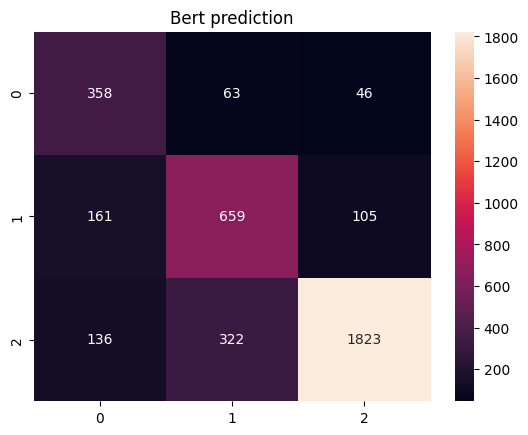

In [ ]:
sns.heatmap(confusion_matrix(y_test_array,y_pred),annot=True, fmt = '.0f')
plt.title("Bert prediction")
plt.show()

# Saving fine tune mode

In [ ]:
# Save the model
torch.save(bert_classifier.state_dict(), 'fine_tuned_bert_model.pth')

# Loading fine tune model

In [ ]:
model = Bertclassifier()
# state_dict = torch.load('/kaggle/working/fine_tuned_bert_model.pth',
#                         map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
state_dict = torch.load('./fine_tuned_bert_model.pth',
                        map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

Bertclassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
def make_prediction(text):
    input_ids_tensor, attention_mask_tensor = bert_preprocessing(np.array([text]))
    input_ids_tensor = input_ids_tensor.to(device)
    attention_mask_tensor = attention_mask_tensor.to(device)

    # print(input_ids_tensor.device)

    with torch.no_grad():
        logits = model(input_ids_tensor,attention_mask_tensor)
        _, predicted = torch.max(logits, dim=1)
    predicted_class = predicted.cpu().numpy().reshape(-1)

    return encoder_bert1.inverse_transform(predicted_class)[0]

In [ ]:
for  i in range(5):
    inference_data = data.sample(n=1)
    text = inference_data['Comment'].values[0]
    label = inference_data['Sentiment'].values[0]
    print
    pred = make_prediction(text)
    print(i+1,text)
    print(f"Orginal Label: {label}")
    print(f"Prediction Label: {pred}")
    print("="*20)

1 great video as always although i dont agree with your views on going into debt i am open to the idea that there are people who know how to use it to increase income i also believe that you can generate income without going into debt
Orginal Label: positive
Prediction Label: positive
2 completely agree with your points in mutation 1 i am twice as good at codingdeveloping as i was last month and i have the urge to go back and fix things that i no longer deem worthy however i got to the point where i realized that just because i am better at in my craft doesnt mean that my old features are bad sometimes simplicity is key i think its about finding the right balance  thank you again for sharing your insights thomas 
Orginal Label: positive
Prediction Label: positive
3 i think cephalopod intelligence is “hard wired” an octopus has a very short lifespan as little as 18 months and has to learn everything from the moment it hatches completely on its own its mother died before it emerged from 